# RNN으로 IMDB 영화리뷰 감정 분류하기
## simpleRNN
### 순환 신경망 RNN
* 시퀀스의 원소를 순회하면서 지금까지 처리한 정보를 **상태(state)**에 저장
* 내부에 loop를 가진 신경망

### numpy로 구현한 간단한 RNN
> RNN 정방향 계산 구현
* input: 크기 (timesteps, input_feature)인 2D 텐서로 인코딩 된 벡터의 시퀀스
    * 시퀀스는 timestep을 따라서 반복됨
    * 각 timestep t에서 현재 상태와 입력을 연결하여 출력으로 계산 -> 출력을 다음 스텝의 상태로 설정
    * 1번째 timestep은 초기상태(0 벡터)로 상태 초기화

In [1]:
import numpy as np

timesteps = 100 # 입력시퀀스에 있는 타임스텝 수
input_features = 32 
output_features = 64

inputs = np.random.random((timesteps, input_features)) # 입력 데이터: 예제를 위해 생성한 난수

state_t = np.zeros((output_features)) # 초기상태: 모두 0인 벡터

W = np.random.random((output_features, input_features)) 
U = np.random.random((output_features, output_features)) 
b = np.random.random((output_features,)) 

successive_outputs = []
for input_t in inputs:
    # 입력과 현재 상태(이전 출력)를 연결하여 현재 출력 얻기
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    # 출력을 리스트에 저장
    successive_outputs.append(output_t)
    # 다음 타임스텝을 위해 네트워크 상태 업데이트
    state_t = output_t
# 최종 출력    
final_output_sequence = np.stack(successive_outputs, axis=0)

---
## simple RNN으로 영화리뷰 이진분류
### IMDB 데이터 전처리

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용)
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________
데이터 로딩...
17473536/17464789 [==============================] - 0s 0us/step
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


### 임베딩 층과 SimpleRNN층을 사용한 모델 훈련

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 28s 161ms/step - loss: 0.5605 - acc: 0.7012 - val_loss: 0.4230 - val_acc: 0.8186
Epoch 2/10
157/157 [==============================] - 31s 194ms/step - loss: 0.3488 - acc: 0.8580 - val_loss: 0.3844 - val_acc: 0.8432
Epoch 3/10
157/157 [==============================] - 23s 145ms/step - loss: 0.2770 - acc: 0.8903 - val_loss: 0.5120 - val_acc: 0.7856
Epoch 4/10
157/157 [==============================] - 23s 147ms/step - loss: 0.2097 - acc: 0.9205 - val_loss: 0.3829 - val_acc: 0.8498
Epoch 5/10
157/157 [==============================] - 23s 145ms/step - loss: 0.1609 - acc: 0.9421 - val_loss: 0.4598 - val_acc: 0.8268
Epoch 6/10
157/157 [==============================] - 25s 158ms/step - loss: 0.1139 - acc: 0.9618 - val_loss: 0.4203 - val_acc: 0.8710
Epoch 7/10
157/157 [==============================] - 23s 146ms/step - loss: 0.0809 - acc: 0.9722 - val_loss: 0.4648 - val_acc: 0.8304
Epoch 8/10
157/157 [==============================] - 2

### simpleRNN 결과 그래프

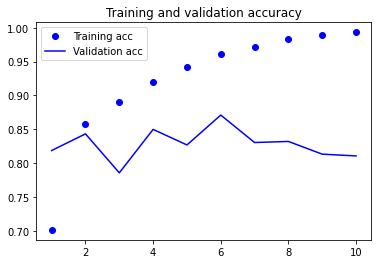

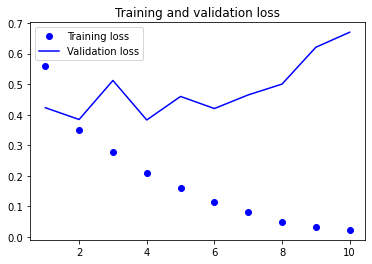

In [3]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

---
## LSTM으로 영화리뷰 이진분류
### LSTM을 사용한 모델 훈련

In [4]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 54s 332ms/step - loss: 0.5518 - acc: 0.7359 - val_loss: 0.3598 - val_acc: 0.8468
Epoch 2/10
157/157 [==============================] - 51s 327ms/step - loss: 0.3073 - acc: 0.8777 - val_loss: 0.3076 - val_acc: 0.8720
Epoch 3/10
157/157 [==============================] - 51s 324ms/step - loss: 0.2471 - acc: 0.9043 - val_loss: 0.3893 - val_acc: 0.8680
Epoch 4/10
157/157 [==============================] - 51s 325ms/step - loss: 0.2054 - acc: 0.9244 - val_loss: 0.3971 - val_acc: 0.8722
Epoch 5/10
157/157 [==============================] - 51s 323ms/step - loss: 0.1828 - acc: 0.9330 - val_loss: 0.2918 - val_acc: 0.8886
Epoch 6/10
157/157 [==============================] - 51s 324ms/step - loss: 0.1613 - acc: 0.9420 - val_loss: 0.3228 - val_acc: 0.8728
Epoch 7/10
157/157 [==============================] - 51s 322ms/step - loss: 0.1483 - acc: 0.9470 - val_loss: 0.3623 - val_acc: 0.8702
Epoch 8/10
157/157 [==============================] - 5

### LSTM 결과 그래프

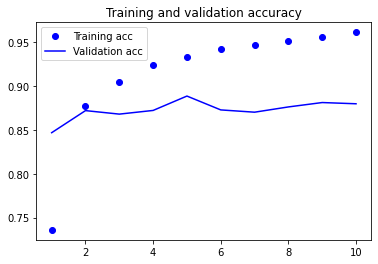

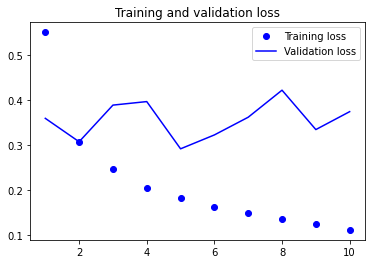

In [5]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()